In [1]:
from pynq import Overlay, allocate, PL
import struct
import numpy
import numpy as np
import pickle
from array import array
from os.path  import join
import random
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

PL.reset()
overlay = Overlay('cnn_fpga.bit')

In [2]:
print('IP blocks :', list(overlay.ip_dict.keys()))

IP blocks : ['conv2D_3x3_32x28x28', 'MaxPooling2D_32x28x28', 'ReLU', 'Linear_12544x128', 'Linear_128x10', 'axi_dma_conv2d_32x28x28_weights', 'axi_dma_conv2d_32x28x28_input', 'axi_dma_maxpool2d_32x28x28_input', 'axi_dma_conv2d_32x28x28_output', 'axi_dma_maxpool2d_32x28x28_output', 'axi_dma_relu_output', 'axi_dma_relu_input', 'axi_dma_linear_12544x128_weights', 'axi_dma_linear_12544x128_bias', 'axi_dma_linear_12544x128_input', 'axi_dma_linear_12544x128_output', 'axi_dma_linear_128x10_weights', 'axi_dma_linear_128x10_bias', 'axi_dma_linear_128x10_input', 'axi_dma_linear_128x10_output', 'processing_system7_0']


In [3]:
#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)        

In [4]:
#
# Set file paths based on added MNIST Datasets
#
input_path = './data/mnist/'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')


#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

In [5]:
#%matplotlib inline

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1
        
#
# Show some random training and test images 
#
#images_2_show = []
#titles_2_show = []
#for i in range(0, 10):
#    r = random.randint(1, 60000)
#    images_2_show.append(x_train[r])
#    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

#for i in range(0, 5):
#    r = random.randint(1, 10000)
#    images_2_show.append(x_test[r])        
#    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

#show_images(images_2_show, titles_2_show)


In [6]:
x = np.array(x_test[0])

print(np.max(x))
print(x.dtype)

x = x[None, :, :]
x = x.astype(np.float32)/255.0

print(np.max(x))
print(x.dtype)

y = y_test[0]

print(x.shape)
print(y)

255
uint8
1.0
float32
(1, 28, 28)
7


In [7]:
def log_softmax(x):
    c = x.max()
    logsumexp = np.log(np.exp(x - c).sum())
    return x - c - logsumexp

In [8]:
def float_to_hex(f):
    return struct.unpack('I', struct.pack('f', f))[0]

def hex_to_float(f):
    return struct.unpack('f', struct.pack('I', f))[0]

def numpy_to_hex(f):
    #assert f.shape
    format_string = f'{f.shape[0]}f'
    packed_data = struct.pack(format_string, *f)
    return packed_data

def hex_to_numpy(f, length):
    format_string = f'{length}f'
    unpacked_data = struct.unpack(format_string, f)
    return np.array(unpacked_data)

data_in = np.array([10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0], dtype=np.float32)
data_hex = numpy_to_hex(data_in)
print(data_hex)
data_out = hex_to_numpy(data_hex, 9)
print(data_out)

b'\x00\x00 A\x00\x000A\x00\x00@A\x00\x00PA\x00\x00`A\x00\x00pA\x00\x00\x80A\x00\x00\x88A\x00\x00\x90A'
[10. 11. 12. 13. 14. 15. 16. 17. 18.]


In [9]:
# Load the .pt file
#with open("mnist_cnn.pt", "rb") as f:
#    data = pickle.load(f)

#load the pre-processed pickle
with open("mnist_cnn.pkl", "rb") as f:
    data = pickle.load(f)
    
# Print the loaded data structure
print(type(data))
print(data.keys())

if isinstance(data, dict):
    for key in data:
        print(f"{key}: {type(data[key])}")

# Example: Convert a specific weight tensor to a NumPy array
weight_key = "conv1.weight"  # Replace with the key you want to inspect

weight_tensor = data[weight_key]
print(len(weight_tensor))
print(len(weight_tensor[0]))
print(weight_tensor[0][0])
# Convert to a NumPy array
weight_array = np.array(weight_tensor[0][0])
print(weight_array)

# Example: Convert a specific weight tensor to a NumPy array
weight_key = "fc1.weight"  # Replace with the key you want to inspect

weight_tensor = data[weight_key]
print(len(weight_tensor))
print(len(weight_tensor[0]))
print(weight_tensor[0][0])
# Convert to a NumPy array
weight_array = np.array(weight_tensor[0][0])
print(weight_array)
    
#if hasattr(data[weight_key], 'numpy'):
#    weight_array = data[weight_key].numpy()  # Convert directly to NumPy array
#else:
#    print("The data format isn't directly convertible. Raw data might need more processing.")

<class 'dict'>
dict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])
conv1.weight: <class 'list'>
conv1.bias: <class 'list'>
conv2.weight: <class 'list'>
conv2.bias: <class 'list'>
fc1.weight: <class 'list'>
fc1.bias: <class 'list'>
fc2.weight: <class 'list'>
fc2.bias: <class 'list'>
32
1
[[0.03838984668254852, -0.39478814601898193, -0.3092019557952881], [0.15461517870426178, -0.3323744535446167, 0.2565317153930664], [0.03815767541527748, 0.3500036299228668, 0.26200997829437256]]
[[ 0.03838985 -0.39478815 -0.30920196]
 [ 0.15461518 -0.33237445  0.25653172]
 [ 0.03815768  0.35000363  0.26200998]]
128
12544
0.0047676535323262215
0.0047676535323262215


In [10]:
class Module():
    def __init__(self, overlay):
        self.overlay = overlay
        self.weights = None
        self.bias = None
        self.output_buffer = None
        self.layer_ip = None
        self.ip_dict = None
        self.dma_send = None
        self.dma_recv = None
        
    def __call__(self, x):
        start_time = time.time()
        output = self.forward(x)
        proc_time = time.time() - start_time
        print(type(self).__name__, " proc time: ", proc_time)
        return output
    
    def forward(self, x):
        pass
    
    #def get_register_offset(self, ip, parameter):
    #    #print(self.overlay.ip_dict[ip]['registers'])
    #    return self.overlay.ip_dict[ip]['registers'][parameter]['address_offset']
        
    def read_param_float(self, param):
        address = self.ip_dict['registers'][param]['address_offset']
        data = self.layer_ip.read(address)
        return hex_to_float(data)
        
    def read_param_hex(self, param):
        address = self.ip_dict['registers'][param]['address_offset']
        data = self.layer_ip.read(address)
        return data

    def write_param_float(self, param, value):
        address = self.ip_dict['registers'][param]['address_offset']
        self.layer_ip.write(address, float_to_hex(value))
    
    def write_param_hex(self, param, value):
        address = self.ip_dict['registers'][param]['address_offset']
        self.layer_ip.write(address, value)
    
    def write_param_numpy(self, param, values):
        #address = self.ip_dict['registers'][param]['address_offset']
        #self.layer_ip.write(address, numpy_to_hex(values.reshape(-1)))
        
        val = values.reshape(-1)
        address = self.ip_dict['registers'][param]['address_offset']
        for i in range(val.size):
            #print("writting: ", val[i], " to: ", address+4*i)
            self.layer_ip.write(address+4*i, float_to_hex(val[i]))
        
    def read_param_numpy(self, param, length=1):
        address = self.ip_dict['registers'][param]['address_offset']
        data = []
        for i in range(length):
            data_ = self.layer_ip.read(offset=address + 4*i)
            data.append(hex_to_float(data_))
        #return hex_to_numpy(data)
        #return hex_to_float(data)
        return np.array(data, dtype=np.float32)
        
    def process_ip(self, in_buffer, out_buffer):
        self.layer_ip.write(0x0, 0x01)
        self.dma_send.transfer(in_buffer)
        self.dma_recv.transfer(out_buffer)
        #print(type(self).__name__, " sending")
        self.dma_send.wait()
        #print(type(self).__name__, " recieving")
        self.dma_recv.wait()

        
class Linear(Module):
    def __init__(self, overlay, in_size, out_size):
        Module.__init__(self, overlay)
        
        self.in_size = in_size
        self.out_size = out_size
        
        self.output_buffer = allocate(shape=(out_size,), dtype=np.float32)
        self.weights_buffer = allocate(shape=(out_size, in_size), dtype=np.float32)
        self.bias_buffer = allocate(shape=(out_size,), dtype=np.float32)

        if in_size == 12544 and out_size == 128:
            self.layer_ip = overlay.Linear_12544x128
            self.ip_dict = overlay.ip_dict['Linear_12544x128']
            self.dma_send_input = overlay.axi_dma_linear_12544x128_input.sendchannel
            self.dma_send_weights = overlay.axi_dma_linear_12544x128_weights.sendchannel
            self.dma_send_bias = overlay.axi_dma_linear_12544x128_bias.sendchannel
            self.dma_recv_output = overlay.axi_dma_linear_12544x128_output.recvchannel
        
        if in_size == 128 and out_size == 10:
            self.layer_ip = overlay.Linear_128x10
            self.ip_dict = overlay.ip_dict['Linear_128x10']
            self.dma_send_input = overlay.axi_dma_linear_128x10_input.sendchannel
            self.dma_send_weights = overlay.axi_dma_linear_128x10_weights.sendchannel
            self.dma_send_bias = overlay.axi_dma_linear_128x10_bias.sendchannel
            self.dma_recv_output = overlay.axi_dma_linear_128x10_output.recvchannel           

    
    def setWeightsAndBias(self, weights, bias):
        assert len(weights.shape) == 2
        assert weights.shape[0] == self.out_size
        assert weights.shape[1] == self.in_size
        
        assert len(bias.shape) == 1
        assert bias.shape[0] == self.out_size
        
        self.weights = weights
        self.bias = bias
        
        #weights should be input:output
        self.weights_buffer[:] = np.transpose(weights, (1, 0))
        self.bias_buffer[:] = bias
        
    def process_ip(self, weights_buffer, bias_buffer, input_buffer, output_buffer):
        self.layer_ip.write(0x0, 0x01)
        self.dma_send_input.transfer(input_buffer)
        self.dma_send_weights.transfer(weights_buffer)
        self.dma_send_bias.transfer(bias_buffer)
        self.dma_recv_output.transfer(output_buffer)
        #print(type(self).__name__, " sending")
        #self.dma_send_input.wait()
        #self.dma_send_weights.wait()
        #self.dma_send_bias.wait()
        self.dma_recv_output.wait()
        #print(type(self).__name__, " recieving")
        #self.dma_recv.wait()
        
    def forward(self, x):
        
        assert len(x.shape) == 1
        assert x.shape[0] == self.in_size
        
        self.process_ip(self.weights_buffer, self.bias_buffer, x, self.output_buffer)
            
        return self.output_buffer
        

class Conv2d(Module):
    def __init__(self, overlay, in_height, in_width, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        Module.__init__(self, overlay)
        
        assert kernel_size == 3
        assert stride == 1
        assert padding == 1
        assert out_channels % 32 == 0
        
        self.layer_ip = overlay.conv2D_3x3_32x28x28
        self.ip_dict = overlay.ip_dict['conv2D_3x3_32x28x28']
        self.dma_send_input = self.overlay.axi_dma_conv2d_32x28x28_input.sendchannel
        self.dma_send_weights = self.overlay.axi_dma_conv2d_32x28x28_weights.sendchannel
        self.dma_recv_output = self.overlay.axi_dma_conv2d_32x28x28_output.recvchannel
        
        self.in_width = in_width
        self.in_height = in_height
        self.in_channels = in_channels
        
        self.out_width = in_width
        self.out_height = in_height
        self.out_channels = out_channels
        
        self.output_buffer = allocate(shape=(self.out_channels, self.out_height, self.out_width), dtype=np.float32)
        self.weights_buffer = allocate(shape=(32, 3, 3), dtype=np.float32)
        self.aux_in_buffer = allocate(shape=(self.in_height, self.in_width), dtype=np.float32)
        self.aux_out_buffer = allocate(shape=(self.out_height, self.out_width, 32), dtype=np.float32)
        
    def setWeightsAndBias(self, weights, bias):
        assert len(weights.shape) == 4
        assert weights.shape[0] == self.out_channels
        assert weights.shape[1] == self.in_channels
        assert weights.shape[2] == 3
        assert weights.shape[3] == 3
        
        assert len(bias.shape) == 1
        assert bias.shape[0] == self.out_channels
        
        self.weights = weights
        self.bias = bias
        
    def process_ip(self, in_buffer, weights_buffer, out_buffer):
        self.layer_ip.write(0x0, 0x01)
        self.dma_send_input.transfer(in_buffer)
        self.dma_send_weights.transfer(weights_buffer)
        self.dma_recv_output.transfer(out_buffer)
        #print(type(self).__name__, " sending")
        #self.dma_send_input.wait()
        #self.dma_send_weights.wait()
        self.dma_recv_output.wait()
        #print(type(self).__name__, " recieving")
        #self.dma_recv.wait()
        
    def forward(self, x):
        
        assert len(x.shape) == 3 
        assert x.shape[0] == self.in_channels
        assert x.shape[1] == self.in_height
        assert x.shape[2] == self.in_width
        
        axi_lite_time = 0.0
        memory_time = 0.0
        process_time = 0.0
        add_time = 0.0

        for in_channel in range(self.in_channels):  
    
            for i in range(self.out_channels//32):
        
                start_time = time.time()
                self.aux_in_buffer[:] = x[in_channel, :, :]
                self.weights_buffer[:] = self.weights[i*32:(i+1)*32, in_channel, :, :]
                memory_time += time.time() - start_time

                start_time = time.time()
                self.process_ip(self.aux_in_buffer, self.weights_buffer, self.aux_out_buffer)
                process_time += time.time() - start_time

                start_time = time.time()
                if in_channel == 0:
                    self.output_buffer[i*32:(i+1)*32, :, :] = np.transpose(self.aux_out_buffer, (2, 0, 1))
                else:
                    self.output_buffer[i*32:(i+1)*32, :, :] += np.transpose(self.aux_out_buffer, (2, 0, 1))
                add_time += time.time() - start_time
            
        for out_channel in range(self.out_channels):      
            self.output_buffer[out_channel, :, :] += self.bias[out_channel]
        
        print("axi_lite_time: ", axi_lite_time)
        print("memory_time: ", memory_time)
        print("process_time: ", process_time)
        print("add_time: ", add_time)
        
        return self.output_buffer        
    

class ReLU(Module):
    def __init__(self, overlay, data_size):
        Module.__init__(self, overlay)
    
        #fpga specific
        self.layer_ip = overlay.ReLU
        self.ip_dict = overlay.ip_dict['ReLU']
        self.dma_send = overlay.axi_dma_relu_input.sendchannel
        self.dma_recv = overlay.axi_dma_relu_output.recvchannel
        
        self.data_size = data_size
        self.output_buffer = allocate(shape=(self.data_size,), dtype=np.float32)
        
    def forward(self, x):
        
        assert x.size == self.data_size 
        
        self.write_param_hex('data_size', self.data_size)

        self.process_ip(x.reshape(-1), self.output_buffer)
        self.output_buffer = self.output_buffer.reshape(x.shape)
            
        return self.output_buffer


class MaxPooling2D(Module):
    def __init__(self, overlay, in_height, in_width, in_channels):
        Module.__init__(self, overlay)
    
        assert in_channels % 32 == 0
    
        self.layer_ip = overlay.MaxPooling2D_32x28x28
        self.ip_dict = overlay.ip_dict['MaxPooling2D_32x28x28']
        self.dma_send = overlay.axi_dma_maxpool2d_32x28x28_input.sendchannel
        self.dma_recv = overlay.axi_dma_maxpool2d_32x28x28_output.recvchannel
        
        self.in_height = in_height
        self.in_width = in_width
        self.in_channels = in_channels
        
        self.out_height = int(in_height/2)
        self.out_width = int(in_width/2)
        self.out_channels = in_channels
                
        self.output_buffer = allocate(shape=(self.out_channels, self.out_height, self.out_width), dtype=np.float32)
        
        self.aux_in_buffer = allocate(shape=(32, self.in_height, self.in_width), dtype=np.float32)
        self.aux_out_buffer = allocate(shape=(32, self.out_height, self.out_width), dtype=np.float32)
        
    def forward(self, x):
        
        assert len(x.shape) == 3
        assert x.shape[0] == self.in_channels
        assert x.shape[1] == self.in_height
        assert x.shape[2] == self.in_width
        
        for i in range(self.out_channels//32):
            self.aux_in_buffer[:, :, :] = x[i*32:(i + 1)*32, :, :]
            self.process_ip(self.aux_in_buffer, self.aux_out_buffer)
            self.output_buffer[i*32:(i+1)*32, :, :] = self.aux_out_buffer[:, :, :]
        
        return self.output_buffer

    
class Net(Module):
    def __init__(self, overlay):
        #super(Net, self).__init__()
        Module.__init__(self, overlay)
        self.conv1 = Conv2d(overlay, 28, 28, 1, 32, 3, 1)
        self.relu1 = ReLU(overlay, 28*28*32)
        self.conv2 = Conv2d(overlay, 28, 28, 32, 64, 3, 1)
        self.relu2 = ReLU(overlay, 28*28*64)
        self.max_pool2d = MaxPooling2D(overlay, 28, 28, 64)
                
        #self.dropout1 = Dropout(0.25)
        #self.dropout2 = Dropout(0.5)
        self.fc1 = Linear(overlay, 14*14*64, 128)
        self.relu3 = ReLU(overlay, 128)
        self.fc2 = Linear(overlay, 128, 10)
            
    def load_state_dict(self, pickle_file):
        #load the pre-processed pickle
        with open(pickle_file, "rb") as f:
            data = pickle.load(f)
    
        conv1_weight = np.array(data["conv1.weight"], dtype=np.float32)
        conv1_bias = np.array(data["conv1.bias"], dtype=np.float32)
        
        self.conv1.setWeightsAndBias(conv1_weight, conv1_bias)
        
        conv2_weight = np.array(data["conv2.weight"], dtype=np.float32)
        conv2_bias = np.array(data["conv2.bias"], dtype=np.float32)
        
        self.conv2.setWeightsAndBias(conv2_weight, conv2_bias)
          
        fc1_weight = np.array(data["fc1.weight"], dtype=np.float32)
        fc1_bias = np.array(data["fc1.bias"], dtype=np.float32)
        
        #print("weight shape: ", fc1_weight.shape)
        #print("bias shape: ", fc1_bias.shape)
        self.fc1.setWeightsAndBias(fc1_weight, fc1_bias)
        
        fc2_weight = np.array(data["fc2.weight"], dtype=np.float32)
        fc2_bias = np.array(data["fc2.bias"], dtype=np.float32)
        
        self.fc2.setWeightsAndBias(fc2_weight, fc2_bias)
            
    def forward(self, x):
        #print("input: ", x)
        x = self.conv1(x)
        #print("after conv1: ", x)
        x = self.relu1(x)
        #print("after relu: ", x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.max_pool2d(x)
        #x = self.dropout1(x)
        #x = torch.flatten(x, 1)
        x = x.reshape(-1)
        x = self.fc1(x)
        x = self.relu3(x)
        #x = self.dropout2(x)
        x = self.fc2(x)
        output = log_softmax(x)
        return output

In [11]:
model = Net(overlay)
model.load_state_dict("mnist_cnn.pkl")

input_buffer = allocate(shape=(1,28,28), dtype=np.float32)

for i in range(10):
    input_buffer[0, :, :] = np.array(x_test[i])
    input_buffer = input_buffer/255.0
    output = model(input_buffer)
    prediction = np.argmax(output)
    print("gt: ", y_test[i], " pred: ", prediction)

axi_lite_time:  0.0
memory_time:  0.0005064010620117188
process_time:  0.009675025939941406
add_time:  0.0038187503814697266
Conv2d  proc time:  0.03976607322692871
ReLU  proc time:  0.006289482116699219
axi_lite_time:  0.0
memory_time:  0.0263364315032959
process_time:  0.08896088600158691
add_time:  0.2664346694946289
Conv2d  proc time:  0.4081134796142578
ReLU  proc time:  0.0031456947326660156
MaxPooling2D  proc time:  0.004704713821411133
Linear  proc time:  0.02150583267211914
ReLU  proc time:  0.0013344287872314453
Linear  proc time:  0.0014414787292480469
Net  proc time:  0.508115291595459
gt:  7  pred:  4
axi_lite_time:  0.0
memory_time:  0.0003974437713623047
process_time:  0.0014996528625488281
add_time:  0.0022013187408447266
Conv2d  proc time:  0.016576051712036133
ReLU  proc time:  0.0015299320220947266
axi_lite_time:  0.0
memory_time:  0.02517843246459961
process_time:  0.08627176284790039
add_time:  0.26387572288513184
Conv2d  proc time:  0.4012744426727295
ReLU  proc t

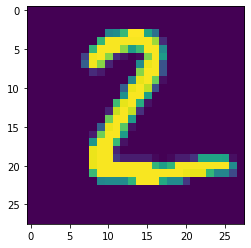

In [12]:
%matplotlib inline

image = x_test[1]
imgplot = plt.imshow(image)
plt.show()